This notebook is used to calculate the differential abundance of OTUs in soils with PyOM or stover additions, as compared to soil only plots

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in last
library(ggplot2)
library(foreach)
library(doParallel)
library(RColorBrewer)
library(gridExtra)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package:

In [143]:
%%R
#Creating the physeq object from our tree and biom table with taxonimic and metadata already included, telling it \
# that the taxonomy is from greengenes database, so it will recognize the samples
physeq = import_biom("../data/otu_table_tax_no211_meta.biom")
sample.data = import_qiime_sample_data("../data/MapFile.txt")
# combines the otu table and the mapping file
physeq = merge_phyloseq(physeq,sample.data)
sample.data = sample_data(physeq)

In [144]:
%%R
#run deseq on each subset (mdply)
#indep filtering
#adjust p values
# write to file in data
Dif_Abund = function(Day, Amdmt){
    physeq.pruned <- prune_samples((sample.data$Day == Day)& ((sample.data$Amdmt == Amdmt) | (sample.data$Amdmt == 0)), physeq)
    dseq = phyloseq_to_deseq2(physeq.pruned, ~Amdmt)
    dseq = DESeq(dseq, quiet = TRUE, fitType = "local")
    results = results(dseq)
    results$Day = Day
    results$Amdmt = Amdmt
    results = data.frame(results$Day,results$Amdmt,rownames(results),results$baseMean,results$log2FoldChange,results$lfcSE,results$pvalue)
    colnames(results) = c("Day","Amdmt","OTU","baseMean","l2FC","SE","pvalue")
    results
    }

In [145]:
%%R
    physeq.pruned <- prune_samples((sample.data$Day == Day)& ((sample.data$Amdmt == Amdmt) | (sample.data$Amdmt == 0)), physeq)
    dseq = phyloseq_to_deseq2(physeq.pruned, ~Amdmt)
    dseq = DESeq(dseq, quiet = TRUE, fitType = "local")

Error in prune_samples((sample.data$Day == Day) & ((sample.data$Amdmt ==  : 
  error in evaluating the argument 'samples' in selecting a method for function 'prune_samples': Error: object 'Day' not found


In [161]:
%%R
variables = expand.grid(Amdmt = c("1", "2"),
                        Day = c(1, 2))

In [162]:
%%R
variables

  Amdmt Day
1     1   1
2     2   1
3     1   2
4     2   2


In [163]:
%%R
DA<-mdply(variables,Dif_Abund)
DA <- DA[,3:9]

converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
Error in `[.data.frame`(DA, , 3:9) : undefined columns selected
In addition: Warning messages:
1: In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
2: In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
3: In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
4: In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
5: In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
6: In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
7: In D

In [164]:
%%R
head(DA)

  Day Amdmt     OTU   baseMean        l2FC         SE    pvalue
1   1     1  OTU.43  223.48048 -0.11012779 0.29052924 0.7046439
2   1     1   OTU.2 1664.01427  0.11095267 0.07837381 0.1568676
3   1     1 OTU.187  362.13258  0.06605159 0.15991481 0.6795756
4   1     1 OTU.150   39.05672  0.03205671 0.15816953 0.8393906
5   1     1  OTU.91   62.21140 -0.01718316 0.37497442 0.9634498
6   1     1 OTU.305   37.70726 -0.14629517 0.27103038 0.5893528


In [165]:
%%R
threshold = function (thresh){
    dplyr::filter(DA, baseMean >= thresh) %>% 
    dplyr::mutate(padj = p.adjust(pvalue,"BH")) %>%
    dplyr::summarize(threshold=thresh, count=sum(padj<=0.10, na.rm = TRUE))
}
# mutate adds a column

In [166]:
%%R
range = seq(0,1,0.1)

In [167]:
%%R
thresh.s <- ldply(range, threshold)

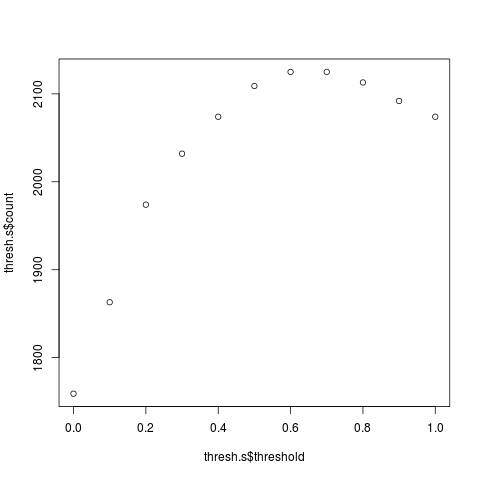

In [168]:
%%R
plot(thresh.s$count~thresh.s$threshold)

In [169]:
%%R
filter(DA,baseMean>=0.6) %>% mutate(padj = p.adjust(pvalue,"BH")) %>% write.csv("../data/l2fc.csv", row.names=FALSE)

In [170]:
!head ../data/l2fc.csv | cut -c 1-80

"Day","Amdmt","OTU","baseMean","l2FC","SE","pvalue","padj"
1,"1","OTU.43",223.480476760568,-0.110127792559516,0.290529241717165,0.704643875
1,"1","OTU.2",1664.01427323273,0.110952667246641,0.0783738103853471,0.1568676044
1,"1","OTU.187",362.132576964478,0.0660515941822755,0.159914812466415,0.67957556
1,"1","OTU.150",39.0567230436438,0.0320567063241244,0.158169528121542,0.83939056
1,"1","OTU.91",62.2114018390707,-0.0171831613331207,0.374974418838079,0.96344982
1,"1","OTU.305",37.7072580260407,-0.146295170832724,0.271030375040768,0.58935284
1,"1","OTU.25",187.19887275687,0.0945287904788471,0.241875397098751,0.6959332006
1,"1","OTU.4258",216.80811533347,-0.0986802477067795,0.111800295183156,0.3774267
1,"1","OTU.453",49.5655884056922,-0.172410725872039,0.1511126220515,0.2538940912


In [171]:
!wc -l ../data/l2fc.csv

15233 ../data/l2fc.csv
